# О вкусной и здоровой пище: предсказываем рейтинг ресторанов Европы

**Цель**: подготовить датасет для использования в модели для предсказания рейтинга ресторанов.

**Задачи**:

* Поработать с пропущенными значениями.
* Создать новые признаки (переменные) на основе имеющихся.
* Поработать над форматом значений переменных: перевести в числовой формат.
* Поработать немного со статистикой и визуализацией, для обоснования решений об очистке или создании новых признаков.
* Обучить модель, поработать с метрикой МАЕ и сделать submission на Kaggle.

### Описание датасета и загрузка библиотек:

**Первоначальная версия датасета** состоит из десяти столбцов, содержащих следующую информацию:

- Restaurant_id — идентификационный номер ресторана / сети ресторанов;
- City — город, в котором находится ресторан;
- Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
- Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
- Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
- Price Range — диапазон цен в ресторане;
- Number of Reviews — количество отзывов о ресторане;
- Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
- URL_TA — URL страницы ресторана на TripAdvosor;
- ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Загружаем данные, делаем разметку:

In [61]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [62]:
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(
    drop=True)  # объединяем

# Изучим целевую переменную `Rating`

Какие значения может принимать целевая переменная?

In [8]:
data['Rating'].unique()

array([0. , 3.5, 4. , 4.5, 5. , 3. , 2.5, 2. , 1. , 1.5])

Видим, что рейтинг ресторанов варьируется от 1 до 5 с шагом в 0.5. Довольно полезная информация. В будущем будет иметь смысл округлить предсказание рейтинга до ближайшего 0.5, чтобы уменьшить ошибку. 

Посмотрим на распределение:

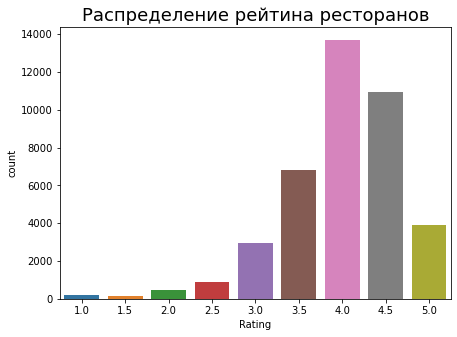

In [9]:
g = sns.countplot(x='Rating', data=data[data.Rating > 0]).set_title(  # значения с рейтингом 0 мы создали сами - уберем их пока
    'Распределение рейтина ресторанов', size=18)
g.figure.set_size_inches(7, 5)

По графику видно, что большинство поставленных оценок было в диапазоне от 3.5 до 4.5. Наивысших оценок (5) - довольно мало, но и очень низких тоже немного. 

Посчитаем некоторые базовые статистики для целевой переменной:

In [11]:
stats = pd.DataFrame([{'Mean': round(data[data['Rating'] > 0]['Rating'].mean(), 2),
                       'Median': round(data[data['Rating'] > 0]['Rating'].median(), 2),
                       'SD': round(data[data['Rating'] > 0]['Rating'].std(), 2)}])
stats

,Mean,Median,SD
0,3.99,4.0,0.67


Медиана и среднее для нашей целевой переменной практически идентичны и равны 4. Стандартное отклонение - 0.67.

# Идентификатор ресторана 

Сколько уникальных заведений представлено в датасете (`Restaurant_id`)?

In [12]:
print('Уникальных заведений:', round(
    data['Restaurant_id'].nunique()/len(data), 1)*100, '%')

Уникальных заведений: 30.0 %


В датасете только около 1/3 всех ресторанов - уникальные. Однако признак `Restaurant_id` никак не помогает нам в предсказании рейтинга, поэтому имеет смысл его удалить.

In [13]:
data = data.drop('Restaurant_id', axis=1)

Посмотрим, какие ещё переменные аналогично не представляют ценности для предсказания рейтинга:

# Ссылка & идентификатор на Trip Advisor

Как выглядит значение переменной `URL_TA` (ссылка на Trip Advisor):

In [14]:
data['URL_TA'][0]

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

Видим, что никакой полезной информации вычленить отсюда так же не получится. Уберем эту переменную из датасета.

In [15]:
data = data.drop('URL_TA', axis=1)

Посмотрим на переменную id ресторана аналогичным образом:

In [16]:
data['ID_TA'][0]

'd10746918'

Данная переменная тоже не несет смысловой нагрузки. Уберем ее из датасета:

In [17]:
data = data.drop('ID_TA', axis=1)

# Ценовой диапазон 

Посмотрим сколько уникальных значений содержится в переменной `Price range`:

In [18]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

Видим, что ценовой диапазон ресторанов в датасете варьируется в пределах трех категорий: "низкий", "средний" и "высокий". Больше всего ресторанов из среднего ценового диапазона.

Сразу же посмотрим на пропущенные значения:

In [19]:
print('Пропущенных значений в переменной Price Range:', round(
    data['Price Range'].isna().sum()/len(data), 2)*100, '%')

Пропущенных значений в переменной Price Range: 35.0 %


Довольно много пропущенных значений, поэтому удалить их все точно не вариант. Попробуем заменить пропуски самым частым значеним - средней ценовой категорие ресторанов, а также переименуем каждую из трех известных категорий (в слово вместо символа):

In [20]:
data['Price Range'] = np.where(data['Price Range'] == '$', 'low',
                               np.where(data['Price Range'] == '$$ - $$$', 'medium',
                                        np.where(data['Price Range'] == '$$$$', 'high', 'medium')))

Посмотрим что получилось:

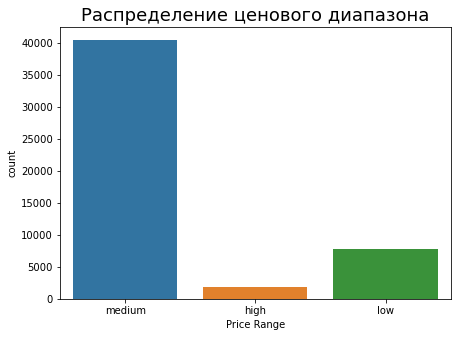

In [22]:
g1 = sns.countplot(x='Price Range', data=data).set_title(
    'Распределение ценового диапазона', size=18)
g1.figure.set_size_inches(7, 5)

Все как и ожидалось: имеем 3 значения в переменной. Посмотрим повнимательнее на распределение:

In [23]:
price_range = pd.DataFrame(
    {'Share': data['Price Range'].value_counts(normalize=True)})
price_range = price_range.reset_index().rename(
    columns={'index': 'Price Range'})
round(price_range, 2)

,Price Range,Share
0,medium,0.81
1,low,0.16
2,high,0.04


Видим, что сейчас более 80% ресторанов попадают в категорию среднего ценового диапазона, и всего лищь 4% ресторанов попадают в категорию элитных.

А теперь посмотрим на взаимосвязь с целевой переменной:

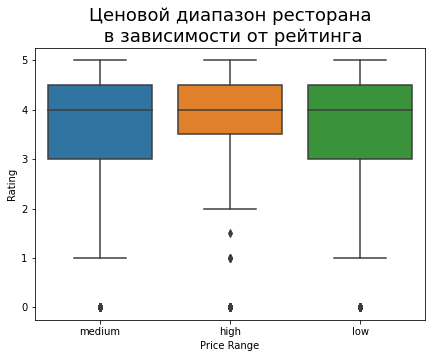

In [24]:
g2 = sns.boxplot(x='Price Range', y='Rating', data=data).\
    set_title('Ценовой диапазон ресторана\n в зависимости от рейтинга', size=18)
g2.figure.set_size_inches(7, 5)

По графику видно, что разброс оценок и медианное значение ресторанов средней ценовой категории практически идентичен аналогичной метрике у ресторанов с низкой ценовой категорией.

Также стоит отметить, что межквартильный разах рейтингов элитных ресторанов значительно меньше, чем в других категориях, однако медианное значение практически идентично ресторанам из средней и низкой ценовой категории.

Наконец, сделаем из этой переменной **dummy**, поскольку в модели следует использовать только количественные данные. Также удалим изначальную переменную `Price Range`.

In [25]:
dummies = pd.get_dummies(data['Price Range'])  # создаем dummy переменные

In [26]:
# добавляем их к изначальному датасету
data = pd.concat([data, dummies], axis=1)
data.head(3)

,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,sample,Rating,high,low,medium
0,Paris,"['Bar', 'Pub']",12963.0,medium,4.0,"[[], []]",0,0.0,0,0,1
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,medium,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0,0,1
2,Edinburgh,['Vegetarian Friendly'],810.0,medium,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",0,0.0,0,0,1


In [27]:
data = data.drop('Price Range', axis=1)

# Город

Посмотрим на количество уникальных городов:

In [28]:
len(data['City'].value_counts())

31

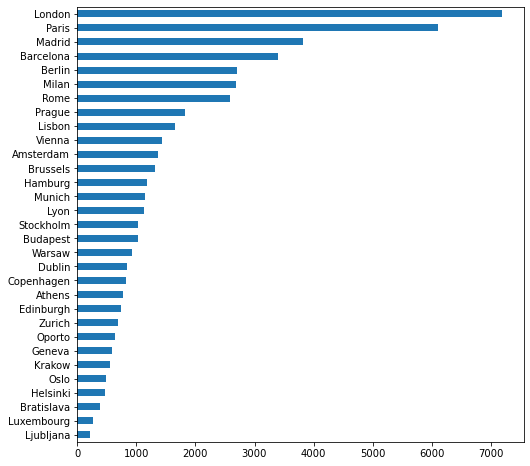

In [29]:
g3 = data['City'].value_counts(ascending=True).plot(kind='barh')
g3.figure.set_size_inches(8, 8)

По графику видно, что большинство ресторанов в нашей выборке находятся в Лондоне, Париже и Мадриде. В общем и целом городов не так много, поэтому для большей точности модели превратим эту переменную в dummy.

In [30]:
dummies1 = pd.get_dummies(data['City'])  # создаем dummy переменные

In [31]:
# добавляем их к изначальному датасету
data = pd.concat([data, dummies1], axis=1)
data.head(2)  # проверяем, что все хорошо

,City,Cuisine Style,Ranking,Number of Reviews,Reviews,sample,Rating,high,low,medium,...,Munich,Oporto,Oslo,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich
0,Paris,"['Bar', 'Pub']",12963.0,4.0,"[[], []]",0,0.0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",0,0.0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


В конце удаляем переменную из которой получили дамми переменные:

In [32]:
data = data.drop('City', axis=1)

# Ранг ресторана в своем городе

Посмотрим на распределение рангов ресторанов:

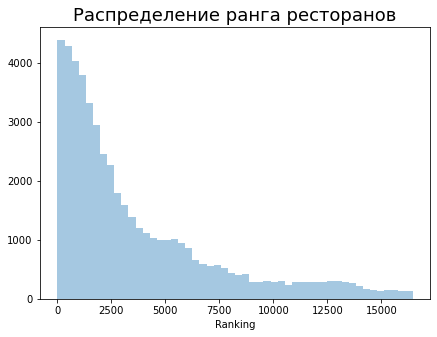

In [33]:
g4 = sns.distplot(a=data['Ranking'], hist=True, kde=False, rug=False).set_title(
    'Распределение ранга ресторанов', size=18)
g4.figure.set_size_inches(7, 5)

In [34]:
data['Ranking'].isna().sum()  # пропущенных значений нет

0

По графику видим, что ранг ресторана варьируется от 0 до (приблизительно) 16.5 тысяч. 

Таким образом, переменная уже готова для использования в модели и не требует дополнительных модификаций.

# Количество отзывов

Посмотрим на распределение количества отзывов:

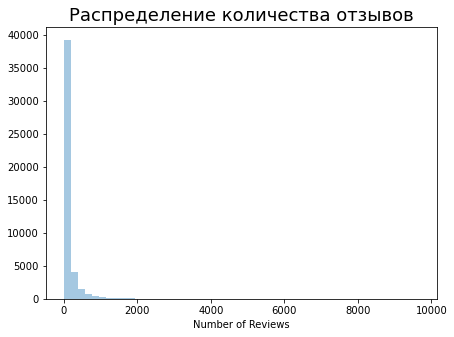

In [35]:
g5 = sns.distplot(a=data['Number of Reviews'], hist=True, kde=False, rug=False).\
    set_title('Распределение количества отзывов', size=18)
g5.figure.set_size_inches(7, 5)

По графику видим, что количество отзывов у ресторанов может достигать примерно 10 000. Однако подавляющее большинство ресторанов в нашей выборке получили приблизительно до 1000 отзывов.

Поработаем с пропущенными значениями:

In [36]:
print('Количество пропущенных значений в переменной Number of Reviews:', round(data['Number of Reviews'].
                                                                               isna().sum()/len(data)*100, 1), '%')

Количество пропущенных значений в переменной Number of Reviews: 6.4 %


Видим, что существует небольшое количество наблюдений, где `Number of Reviews` не указано, однако совсем удалять их все равно не хочется. Заменим все пропуски **медианным значением** (очевидно, что замена средним не подходит):

In [37]:
data['Number of Reviews'] = data['Number of Reviews'].fillna(
    data['Number of Reviews'].median())  # заменяем пропуски медианой

In [38]:
data['Number of Reviews'].isna().sum()  # проверим их отсутствие, все хорошо

0

Теперь переменную можно использовать для добавления в модель.

# Кухня

Посмотрим, как выглядит типичное значение переменной `Cuisine Style`:

In [63]:
data['Cuisine Style'][4]

"['Italian', 'Mediterranean', 'European', 'Seafood', 'Vegetarian Friendly', 'Gluten Free Options']"

Посмотрим на количество пропущенных значений:

In [64]:
print('Пропущенных значений в переменной Cuisine Style:', round(
    data['Cuisine Style'].isna().sum()/len(data)*100, 1), '%')

Пропущенных значений в переменной Cuisine Style: 23.2 %


Заменим пропуски значением 'other':

In [65]:
data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")

Проверим:

In [66]:
data['Cuisine Style'].isna().sum()  # все правильно

0

**Создадим новые признаки:**

1. Количество кухонь в ресторане (`Num_of_cuisines`)
2. Есть ли в ресторане Vegetarian/Vegan опции (`Veg`)

In [67]:
data['Cuisine Style'] = data['Cuisine Style'].str.findall(
    r"'(\b.*?\b)'")  # сделаем предобработку

Создаем новую переменную, куда запишем количество кухонь в ресторане:

In [68]:
data['Num_of_cuisines'] = data['Cuisine Style'].apply(len)

Проверим. Все верно: каждое слово или словосочетание, разделенное запятой, считается как отдельный вид кухни (верно определили длину списка). Там, где виды кухонь изначально не были указаны, теперь стоит 1 - это наш лучший informed guess.

In [69]:
data['Num_of_cuisines'].head(3)

0    2
1    5
2    1
Name: Num_of_cuisines, dtype: int64

Теперь создадим переменную, которая будет выдавать 1, если в ресторане есть **Vegetarian** или **Vegan** меню, и 0 - если нет.

In [70]:
# для поиска слов превратим список обратно в тип str
data['Cuisine Style'] = data['Cuisine Style'].astype('str')

In [71]:
def count_veg(string):  # создадим функцию, которая принимает на вход строку
    # подсчитывает количество слов в ней, в которые входит 'Veg',т.е. VEGetarian or VEGan
    a = string.count('Veg')
    return a  # возвращает их количество в строке

In [72]:
# применяем эту функцию ко всем наблюдениями в переменной
data['Veg'] = data['Cuisine Style'].apply(count_veg)

Проверяем:

In [73]:
data['Cuisine Style'][1]  # 2 начения нужно найти

"['European', 'Scandinavian', 'Gluten Free Options', 'Vegetarian Friendly', 'Vegan Options']"

In [74]:
data['Veg'][1]  # проверяем, все правильно

2

Наконец, удалим изначальную переменную `Cuisine Style`:

In [75]:
data = data.drop('Cuisine Style', axis=1)

# Отзыв о ресторане

Посмотрим сразу же на пропущенные значения:

In [76]:
data['Reviews'].isna().sum()

2

Пока заполним пропуски так:

In [77]:
data['Reviews'] = data['Reviews'].fillna('[[], []]')

Создадим новые временные переменные - дата отзыва и длина этой новой переменной. Как правило, в переменной Reviews записаны 2 отзыва и 2 даты этих отзывов соответственно. Посмотрим что происходит в других случаях:

In [78]:
data['Date_of_Review'] = data['Reviews'].str.findall(
    '\d+/\d+/\d+')  # переменная с датами

In [79]:
data['Length_date'] = data['Date_of_Review'].apply(lambda x: len(x))
# переменная с количеством элементов в переменной с датами (норма = 2)

Посмотрим, сколько элементов на самом деле имею пустые значения ([]):

In [81]:
print('Количество пустых элементов в переменной Reviews:', round(
    len(data[data['Length_date'] == 0])/len(data)*100, 1), '%')

Количество пустых элементов в переменной Reviews: 16.2 %


Довольно много совсем пустых элементов! Разберемся с ними чуть позже.

Создадим переменную, в которой запишем количество дней, которое прошло с момента написания последнего (самого свежего) отзыва:

In [82]:
def time_to_now(row):
    if row['Date_of_Review'] == []:
        return None
    return datetime.datetime.now() - pd.to_datetime(row['Date_of_Review']).max()

In [83]:
data['Days_to_now'] = data.apply(time_to_now, axis=1).dt.days

Повнимательнее посмотрим на получившуюся переменную:

In [84]:
print('median:', data['Days_to_now'].median())
data['Days_to_now'].describe()

median: 1161.0


count    41886.000000
mean      1298.045361
std        363.252094
min       1008.000000
25%       1087.000000
50%       1161.000000
75%       1345.000000
max       6067.000000
Name: Days_to_now, dtype: float64

По-прежнему нужно что-то сделать с пропусками: заполним все пропуски в новой переменной медианным значением (ничего более креативного больше в голову совсем не приходит)

In [85]:
data['Days_to_now'] = data['Days_to_now'].fillna(
    data['Days_to_now'].median())  # заменяем пропуски медианой

Удалим все переменные, которые больше не нужны:

In [86]:
data = data.drop('Reviews', axis=1)

In [87]:
data = data.drop('Date_of_Review', axis=1)

In [88]:
data = data.drop('Length_date', axis=1)

Итак, датасет готов для использования в модели!

# Соберем всю предобработку в одну функцию

Подгрузим данные ещё раз, а затем применим все преобразования через функцию:

In [90]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями
df_test['Rating'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)

Объединим всю обработку в одну функцию:

In [91]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    data = df_input.copy()

    # ################### 1. Restaurant_id, URL_TA & ID_TA ###################################################
    data = data.drop('Restaurant_id', axis=1)
    data = data.drop('URL_TA', axis=1)
    data = data.drop('ID_TA', axis=1)

    # ################### 2. Price Range ##############################################################
    data['Price Range'] = np.where(data['Price Range'] == '$', 'low',
                                   np.where(data['Price Range'] == '$$ - $$$', 'medium',
                                            np.where(data['Price Range'] == '$$$$', 'high', 'medium')))

    dummies = pd.get_dummies(data['Price Range'])
    data = pd.concat([data, dummies], axis=1)
    data = data.drop('Price Range', axis=1)

    # ################### 3. City ##############################################################
    dummies1 = pd.get_dummies(data['City'])
    data = pd.concat([data, dummies1], axis=1)
    data = data.drop('City', axis=1)

    # ################### 4. Number of Reviews ####################################################
    data['Number of Reviews'] = data['Number of Reviews'].fillna(
        data['Number of Reviews'].median())

    # ################### 5. Cuisine Style ####################################################
    data['Cuisine Style'] = data['Cuisine Style'].fillna("['Other']")
    data['Cuisine Style'] = data['Cuisine Style'].str.findall(r"'(\b.*?\b)'")
    data['Num_of_cuisines'] = data['Cuisine Style'].apply(len)
    data['Cuisine Style'] = data['Cuisine Style'].astype('str')

    def count_veg(string):
        a = string.count('Veg')
        return a

    data['Veg'] = data['Cuisine Style'].apply(count_veg)
    data = data.drop('Cuisine Style', axis=1)

    # ################### 6. Reviews ####################################################
    data['Reviews'] = data['Reviews'].fillna('[[], []]')
    data['Date_of_Review'] = data['Reviews'].str.findall('\d+/\d+/\d+')
    data['Length_date'] = data['Date_of_Review'].apply(lambda x: len(x))

    def time_to_now(row):
        if row['Date_of_Review'] == []:
            return None
        return datetime.datetime.now() - pd.to_datetime(row['Date_of_Review']).max()

    data['Days_to_now'] = data.apply(time_to_now, axis=1).dt.days
    data['Days_to_now'] = data['Days_to_now'].fillna(
        data['Days_to_now'].median())
    data = data.drop('Reviews', axis=1)
    data = data.drop('Date_of_Review', axis=1)
    data = data.drop('Length_date', axis=1)
    # ################### ####################################################

    return data

In [92]:
df_processed = preproc_data(data)

In [95]:
df_processed.head(3)  # все хорошо

,Ranking,Number of Reviews,sample,Rating,high,low,medium,Amsterdam,Athens,Barcelona,...,Paris,Prague,Rome,Stockholm,Vienna,Warsaw,Zurich,Num_of_cuisines,Veg,Days_to_now
0,12963.0,4.0,0,0.0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,2,0,1161.0
1,106.0,97.0,0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,5,2,1091.0
2,810.0,28.0,0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,1068.0


# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [96]:
# выделим тестовую часть
train_data = df_processed.query('sample == 1').drop(['sample'], axis=1)
test_data = df_processed.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values  # у - целевая переменная (рейтинги ресторанов)
# Х - данные с информацией о ресторанах
X = train_data.drop(['Rating'], axis=1)

In [97]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [98]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
RANDOM_SEED = 7
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_SEED)

In [99]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 40), (40000, 40), (40000, 39), (30000, 39), (10000, 39))

# Создаём, обучаем и тестируем модель

In [100]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [101]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred

y_pred = regr.predict(X_test)

In [102]:
# округлим предсказания до ближайшего 0.5
y_pred = np.round(0.5*np.round(y_pred/0.5), 1)
y_pred

array([4. , 4. , 5. , ..., 4. , 5. , 4.5])

In [103]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.18245


Получили адекватный результат, который немного лучше, чем МАЕ baseline модели (MAE = ~0.21).

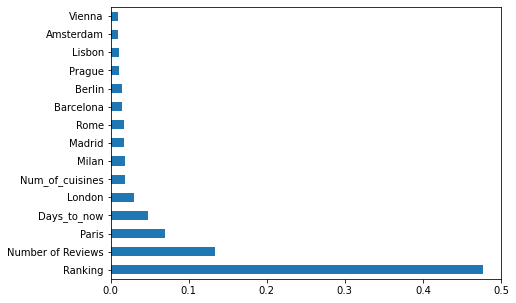

In [104]:
# посмотрим на самые важные признаки для модели
plt.rcParams['figure.figsize'] = (7, 5)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Видим, что самыми важными признаками явдяются: ранг ресторана в городе, количество отзывов на ресторан, факт нахождения ресторана в Париже и количество дней, прошедших с даты написания последнего отзыва доя сегодняшнего дня.

# Создаем файл для submission

In [105]:
test_data = test_data.drop(['Rating'], axis=1)  # тестовые данные

In [106]:
# делаем предсказание на тестовых данных
predict_submission = regr.predict(test_data)

In [107]:
# округляем результаты до ближайшего 0.5
predict_submission = np.round(0.5*np.round(predict_submission/0.5), 1)
predict_submission

array([3. , 4. , 4.5, ..., 3. , 4. , 4.5])

In [108]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.5
3,id_3,4.5
4,id_4,4.5
